### Utilitary Functions
Definition of functions that don't belong to a specific class inside the logic of the problem solution

In [144]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import math
import copy

%matplotlib inline

def pseudo_transpose(listt):
    '''
    Utilitary function used to compute the transpose of a matrix 
    expressed in the shape of a vector
    '''
    result = np.empty(9)
    for i in range(9):
        result[i] = listt[3 * (i % 3) + math.floor(1 / 3)]
    return result


def moving_average(a, n=5) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot_agents_avg_reward(title, data, styles, labels):
    #sns.set_style('white')
    #sns.set_context('talk')
    plt.subplot(1, 1, 1)
    plt.title(title)
    for i in range(len(data)):
        plt.plot(range(len(data[i])), data[i], styles[i], label = labels[i])
    plt.ylabel('Average Reward')
    plt.xlabel('Time Step')
    plt.legend(loc=4, bbox_to_anchor=(1.5, 0))
    #sns.despine()
    plt.show()

### Game
Definition of the class that represents a game. Important methods for this experiments are the ones related with joint actions. The game class makes sure that agent1 and agent2 get the corresponding feedback of each other so that they can update they shared knowledge and obtain a solution based on it.

In [145]:
class Game(object):
    '''
    Definition of the game values and game actions (play) based on the involved agents
    '''
    def __init__(self, game_values, iterations, agent1, agent2):
        self.game_values = game_values
        self.iterations = iterations
        self.agent1 = agent1
        self.agent2 = agent2
        self.history_values_agent1 = []
        self.history_values_agent2 = []
    
    def run(self):
        for i in range(self.iterations):
            self.agent1.compute_action()
            self.agent2.compute_action()
            self.play(self.agent1.last_action, self.agent2.last_action)
    
    def play(self, action_agent1, action_agent2):
        '''
        Defines a step in the game. Based on the input actions, the output of the game is
        computed for a joint scenario
        '''
        value = self.get_game_value(action_agent1, action_agent2)
        
        agent1.add_action_value(action_agent1, value[0])
        agent2.add_action_value(action_agent2, value[1])
        
        self.agent1.add_extended_action_value(agent1.last_action * 3 + agent2.last_action , value[0])
        self.agent2.add_extended_action_value(agent2.last_action * 3 + agent1.last_action, value[1])
        return value
        
    def run_joint(self, experiments = 1):
        history_values_agent1 = np.empty((experiments, iterations))
        history_values_agent2 = np.empty((experiments, iterations))
        for e in range(experiments):
            self.agent1.reset()
            self.agent2.reset()
            for i in range(self.iterations):
                tmp_agent1_values = copy.copy(self.agent1.extended_values)
                tmp_agent1_actions_count = copy.copy(self.agent1.extended_actions_count)
                self.agent1.compute_action_joint(self.agent2.extended_values, self.agent2.extended_actions_count, i)
                self.agent2.compute_action_joint(tmp_agent1_values, tmp_agent1_actions_count, i)
                value = self.play(self.agent1.last_action, self.agent2.last_action)
                history_values_agent1[e][i] = value[0]
                history_values_agent2[e][i] = value[1]
        
        self.history_values_agent1 = np.mean(history_values_agent1, axis=0)
        self.history_values_agent2 = np.mean(history_values_agent2, axis=0)
            
        
    def get_game_value(self, position_1, position_2):
        '''
        Obtains a tuple with the values for the players after each of them choose an
        action/position to play. Player 1 is the row player and Player 2 the column one
        '''
        return (np.random.normal(self.game_values[position_1][position_2][0], 
                                self.game_values[position_1][position_2][1]),
                np.random.normal(self.game_values[position_1][position_2][0], 
                                self.game_values[position_1][position_2][1]))

### Agent
Definition of the agent class which contains the history of the values and the methods to select a position for the game and play it.

In [146]:
class Agent(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.actions_count = np.ones(3) # count for the action taken
        self.values = np.zeros(3) # values obtained so far -> average
    
    def compute_action(self, iteration = None):
        '''
        Gets the position/action for the following game based on the policy of the agent.
        For this base class the policy follows a random choice
        '''
        action = np.random.choice(3)
        self.last_action = action
        self.actions_count[action] += 1
    
    def add_action_value(self, action, value):
        self.values[action] = ((self.values[action] * (self.actions_count[action] - 1) + value) 
                               / (self.actions_count[action]))
        
class BoltzmannActionLearner(Agent):
    def __init__(self, t):
        self.t = t
        super(BoltzmannActionLearner, self).__init__()
        
    def compute_action(self, iteration = None):
        '''
        Gets the position/action for the following game based on the policy of the agent.
        For this class the decision is taken based on the boltzmann definition
        '''
        
        if iteration != None:
            t = 3 * ((self.num_iterations - iteration) / self.num_iterations)
        
        numerator = np.exp(self.values / t)
        denominator = np.sum(numerator)
        pdf = numerator / denominator #probability distribution function
        
        action = np.random.choice(len(self.values), p=pdf)
        self.last_action = action
        self.actions_count[action] += 1 #increment in the counter of the actions
    
class BoltzmannJointActionLearner(Agent):
    def __init__(self, t, num_iterations):
        self.t = t
        self.num_iterations = num_iterations
        super(BoltzmannJointActionLearner, self).__init__()
    
    def __str__(self):
        return 'Boltzamn JAL'
    
    def reset(self):
        self.actions_count = np.ones(3) # count for the action taken
        self.values = np.zeros(3) # values obtained so far -> average
        self.extended_actions_count = np.ones(9)
        self.extended_values = np.zeros(9)
    
    def compute_action(self, iteration = None):
        '''
        Gets the position/action for the following game based on the policy of the agent.
        This method works as a simulation of the two agents into a single agent.
        Not real practical application. Kept as utilitary for possible further testing
        '''
        numerator = np.exp(self.values / t)
        denominator = np.sum(numerator)
        pdf = numerator / denominator #probability distribution function
        action = np.random.choice(len(self.values), p=pdf)
        self.last_action = action
        self.actions_count[action] += 1
        
    def compute_action_joint(self, external_agent_values, external_agent_actions_count, iteration = None):
        '''
        Gets the position/action for the following game based on the policy of the agent
        and the values of the external agent getting an average of the obtained values.'''
        
        if iteration != None:
            t = 0.05 * ((self.num_iterations - iteration) / self.num_iterations)

        avg_values = ((self.extended_values + pseudo_transpose(external_agent_values)) 
                          / (self.extended_actions_count + pseudo_transpose(external_agent_actions_count)))
        
        numerator = np.exp(avg_values / t)
        denominator = np.sum(numerator)
        pdf = numerator / denominator #probability distribution function
        action = np.random.choice(len(self.extended_values), p=pdf)
        self.last_action = math.floor(action / 3)
        self.actions_count[self.last_action] += 1
    
    def add_extended_action_value(self, action, value):
        self.extended_actions_count[action] += 1
        self.extended_values[action] = ((self.extended_values[action] * 
                                         (self.extended_actions_count[action] - 1) + value) 
                                        / (self.extended_actions_count[action]))
    
class OptimisticBoltzmannJointActionLearner(Agent):
    def __init__(self, t, num_iterations):
        self.t = t
        self.num_iterations = num_iterations
        super(OptimisticBoltzmannJointActionLearner, self).__init__()
    
    def __str__(self):
        return 'Optimistic Boltzamn JAL'
    
    def reset(self):
        self.actions_count = np.zeros(3) # count for the action taken
        self.values = np.zeros(3) # values obtained so far -> average
        self.extended_actions_count = np.ones(9)
        self.extended_values = np.zeros(9)
        self.max_values = np.zeros(9)
    
    def compute_action_joint(self, ext_agent_max_values, ext_agent_actions_count, iteration = None):
        '''
        Gets the position/action for the following game based on the policy of the agent
        and the values of the external agent getting an average of the obtained values.'''
        
        if iteration != None:
            t = 2 * ((self.num_iterations - iteration) / self.num_iterations)
        
        avg_values = (self.max_values + ext_agent_max_values) / 2
        
        numerator = np.exp(avg_values / t)
        denominator = np.sum(numerator)
        pdf = numerator / denominator #probability distribution function
        action = np.random.choice(len(self.extended_values), p=pdf)
        self.last_action = math.floor(action / 3)
        self.actions_count[self.last_action] += 1
    
    def add_action_value(self, action, value):
        '''
        Adds a corresponding action value taking into consideration the posibility
        of a new max value for the chosen action
        '''
        # Re-asign max value if required
        if value >= self.max_values[action]:
            self.max_values[action] = value
            
        self.values[action] = ((self.values[action] * (self.actions_count[action] - 1) + value) 
                               / (self.actions_count[action]))
        
    def add_extended_action_value(self, action, value):
        # Re-asign max value if required
        if value >= self.max_values[action]:
            self.max_values[action] = value
            
        self.extended_actions_count[action] += 1
        self.extended_values[action] = ((self.extended_values[action] 
                                         * (self.extended_actions_count[action] - 1) + value) 
                                        / (self.extended_actions_count[action]))

### Exercise A

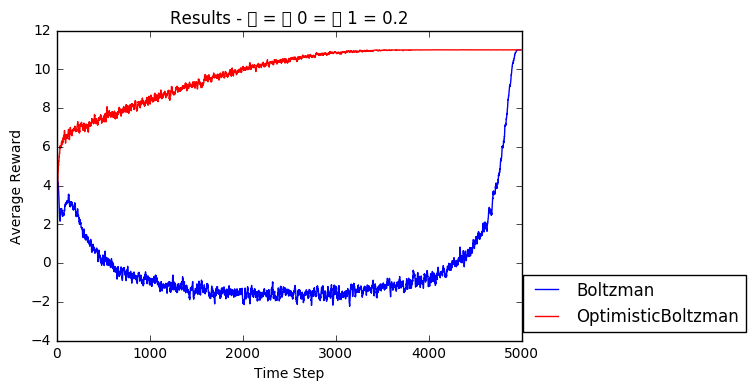

In [147]:
sigma = 0.2
sigma0 = 0.2
sigma1 = 0.2

iterations = 5000
experiments = 500 # Used to compute an average of the iterations and smooth the final charts

game_values = [[(11, sigma0), (-30, sigma), (0, sigma)],
              [(-30, sigma), (7, sigma1), (6, sigma)],
              [(0, sigma), (0, sigma), (5, sigma)]]

agent1 = BoltzmannJointActionLearner(None, iterations)
agent2 = BoltzmannJointActionLearner(None, iterations)

game = Game(game_values, iterations, agent1, agent2)
game.run_joint(experiments)

values_boltzman = moving_average((game.history_values_agent1 
                                  + game.history_values_agent2) / 2, 10)

agent1 = OptimisticBoltzmannJointActionLearner(None, iterations)
agent2 = OptimisticBoltzmannJointActionLearner(None, iterations)

game = Game(game_values, iterations, agent1, agent2)
game.run_joint(experiments)

values_optimistic_boltzman = moving_average((game.history_values_agent1 
                                             + game.history_values_agent2) / 2, 10)

plot_agents_avg_reward('Results - \u03A3 = \u03A3 0 = \u03A3 1 = {}'.format(sigma),
                       [values_boltzman, values_optimistic_boltzman],
                       ['b-', 'r-'], 
                       ['Boltzman', 'OptimisticBoltzman'])

### Exercise B

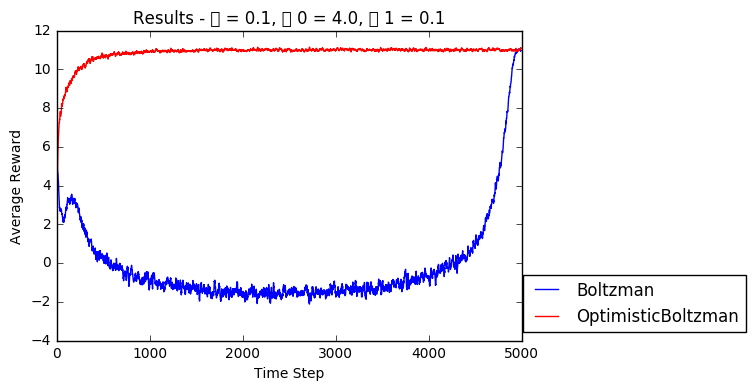

In [148]:
sigma = 0.1
sigma0 = 4.0
sigma1 = 0.1

game_values = [[(11, sigma0), (-30, sigma), (0, sigma)],
              [(-30, sigma), (7, sigma1), (6, sigma)],
              [(0, sigma), (0, sigma), (5, sigma)]]

agent1 = BoltzmannJointActionLearner(None, iterations)
agent2 = BoltzmannJointActionLearner(None, iterations)

game = Game(game_values, iterations, agent1, agent2)
game.run_joint(experiments)

values_boltzman = moving_average((game.history_values_agent1 
                                  + game.history_values_agent2) / 2, 10)

agent1 = OptimisticBoltzmannJointActionLearner(None, iterations)
agent2 = OptimisticBoltzmannJointActionLearner(None, iterations)

game = Game(game_values, iterations, agent1, agent2)
game.run_joint(experiments)

values_optimistic_boltzman = moving_average((game.history_values_agent1 
                                             + game.history_values_agent2) / 2, 10)

plot_agents_avg_reward('Results - \u03A3 = {}, \u03A3 0 = {}, \u03A3 1 = {}'. format(sigma, sigma0, sigma1),
                       [values_boltzman, values_optimistic_boltzman],
                       ['b-', 'r-'], 
                       ['Boltzman', 'OptimisticBoltzman'])

### Exercise C

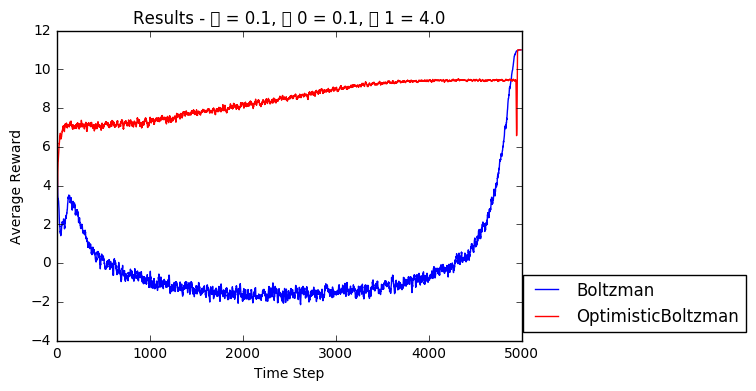

In [149]:
sigma = 0.1
sigma0 = 0.1
sigma1 = 4.0

game_values = [[(11, sigma0), (-30, sigma), (0, sigma)],
              [(-30, sigma), (7, sigma1), (6, sigma)],
              [(0, sigma), (0, sigma), (5, sigma)]]

agent1 = BoltzmannJointActionLearner(None, iterations)
agent2 = BoltzmannJointActionLearner(None, iterations)

game = Game(game_values, iterations, agent1, agent2)
game.run_joint(experiments)

values_boltzman = moving_average((game.history_values_agent1 
                                  + game.history_values_agent2) / 2, 10)

agent1 = OptimisticBoltzmannJointActionLearner(None, iterations)
agent2 = OptimisticBoltzmannJointActionLearner(None, iterations)

game = Game(game_values, iterations, agent1, agent2)
game.run_joint(experiments)

values_optimistic_boltzman = moving_average((game.history_values_agent1 
                                             + game.history_values_agent2) / 2, 10)

plot_agents_avg_reward('Results - \u03A3 = {}, \u03A3 0 = {}, \u03A3 1 = {}'. format(sigma, sigma0, sigma1),
                       [values_boltzman, values_optimistic_boltzman],
                       ['b-', 'r-'], 
                       ['Boltzman', 'OptimisticBoltzman'])